# **ARIMA**

This notebook will include:

1.   ARIMA
2.   SARIMA
3.   SARIMAX

We undergo an iterative testing approach by increasing the complexity of the models via integrating seasonality as well as exogeneous variables.

In [2]:
# Mount Drive on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importing Libraries
import pandas as pd
import numpy as np

from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math
from math import pi
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Set Directory
%cd /content/drive/My Drive/Colab Notebooks/ML Project/

/content/drive/My Drive/Colab Notebooks/ML Project


In [5]:
# Import Datasets
df_test = pd.read_csv("test.csv",parse_dates=['date'], index_col=1)
df_train = pd.read_csv("train.csv", parse_dates=['date'],index_col=0)

### **Lag Plot**
`lag_plot` has a built-in plotting function that plots a time series against a lagged function of itself

In [6]:
# Get distinct storeid and itemid
df_permutations = df_train.groupby(['store', 'item']).size().reset_index().rename(columns={0:'count'})

# There are 500 time serieses, with stores and item ranging from 1-50 and 1-10 respectively.

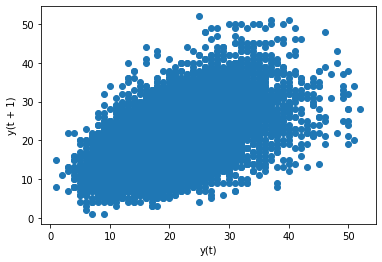

In [7]:
# We do a lag plot of current values against their lags
i = 0

for index, row in df_permutations.iterrows():
  df_individual_train = df_train[(df_train['store']==row['store'])
  & (df_train['item']==row['item'])]

  # # Plot all permutations (500) against their lagged values - too clustered
  # lag_plot(df_individual_train['sales'])

  # # Plot every 1 in 10 permutations against their lagged values
  # if i%10 == 0:
  #   lag_plot(df_individual_train['sales'])
  # i+=1

  # # Plot every 1 in 50 permutations against their lagged values
  # if i%50 == 0:
  #   lag_plot(df_individual_train['sales'])
  # i+=1

  # Plot every 1 in 100 permutations against their lagged values
  if i%100 == 0:
    lag_plot(df_individual_train['sales'])
  i+=1

As observed, the lag plot reveal a certain positive linear relationship between the current values and their corresponding lags. However, there appears to be some noise within the data.

As such, a autoregressive model such as ARIMA could be appropriate.

## **Descriptive Statistics and Tests**

In ARIMA, we first make the data stationary before running ARIMA or in OLS, we check normality, auto-correlation etc. Therefore, the below mentioned tests are important. p,d,q

### **Stationarity Test**

To determine whether a series is stationary we can use the <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller Test</a>. In this test the null hypothesis states that $\phi = 1$ (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.

**Note that some models like Holt-Winters DO NOT need stationary data while others like ARIMA requires stationary data.**

#### **ACF and PACF**

An autocorrelation plot (correlogram) shows the correlation of the series with itself lagged by x time units.

Example: How correlated are today's sales compared to yesterday's sales. (1st order differencing)

1.  **ACF - AutoCorrelation Function Plot**:
It describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.
2.  **PACF - Partial AutoCorrelation Function Plot**: It only describes the direct relationship between an observation and its lag.

> Correlation ranges from -1 (Perfect Negative Correlation) to +1 (Perfect Positive Correlation). The closer the correlation is to 0, the weaker the linear relationship.

In general, the further away you get with the shift, the less likely the time series would be correlated with itself.

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

#### **Using ACF to get I(d)**

**I(d): Integrated**
-   Differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

**Steps:**

Keep differencing the values till the data becomes stationary. We create an adf_test() function tocheck if the data is stationary.

As can be seen below, the data is already stationary and hence there is no need to difference, i.e. d = 0.

**How many times to difference?**

Differencing is a method to transform the data by deducting the current observation by a prior observation with a certain lag. The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

In [8]:
# Define a function that checks whether data is stationary
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    # print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    # print(out.to_string()) # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        # print("Strong evidence against the null hypothesis")
        # print("Reject the null hypothesis")
        # print("Data has no unit root and is stationary")
        return True
    else:
        # print("Weak evidence against the null hypothesis")
        # print("Fail to reject the null hypothesis")
        # print("Data has a unit root and is non-stationary")
        return False

In [ ]:
# Run stationary test across all 500 observations
is_stationary = 0
is_not_stationary = 0

for index, row in df_permutations.iterrows():
  df_individual_train = df_train[(df_train['store']==row['store'])
  & (df_train['item']==row['item'])]

  result = adf_test(df_individual_train['sales'])

  if result == True:
    is_stationary += 1
  else:
    is_not_stationary += 1

print('Stationary:', str(is_stationary))
print('Not Stationary:', str(is_not_stationary))

We observe a vast majority of time serieses to be stationary. Due to the large number of time serieses (500), we will set I(d) to 0 since majority are stationary.

#### **Using PACF to get AR(p)**

**AR(p): Autoregressive**
-   A regression model that utilises the dependent relationship between a current observation and observations over a previous time period.

**Method 1**: Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

> You can observe that the PACF lag 7 is quite significant since is well above the significance line. Therefore, we tentatively fix the p as 7.

**Method 2**: If you observe a sharp cutoff in the PACF plot, consider adding the AR component.

> Since we observe a sharp cutoff after lag 7, it also agrees with our previous method.

In [ ]:
i = 0

for index, row in df_permutations.iterrows():
  df_individual_train = df_train[(df_train['store']==row['store'])
  & (df_train['item']==row['item'])]

  if i%100 == 0:
    plot_pacf(df_individual_train['sales']);
  i+=1

After random sampling and plotting various PACF plots, we observed:

1.   High similarity between all PACF Plots
2.   Methods 1 & 2 support an AR(p) of 7.

As such, we shall use AR(p) = 7.



#### **Using ACF to get MA(q)**

**MA(q): Moving Average**
-   A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

**Method 1**: Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast. We can take the number of lags that are above the significance line.

**Method 2**: The graphs tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

> As such, it is recommended to try q = 0 or 1.

In [ ]:
i = 0

for index, row in df_permutations.iterrows():
  df_individual_train = df_train[(df_train['store']==row['store'])
  & (df_train['item']==row['item'])]

  if i%100 == 0:
    plot_acf(df_individual_train['sales']);
  i+=1

We did the same random sampling across the time serieses, and observe that since ACF decays slowly, method 1 was not suitable. According to method 2, we tentatively set MA(q) = 1.

## **Code**

The first model we tried was the default ARIMA model with the p, d and q values previously obtained.

**Auto-Arima**

We also tried auto-arima, which was an automatic grid-search approach to identify the best parameters. However, the model was very slow, with each run taking more than 10 minutes. If we were to run all 500 models, it would take more than 3 days to run. Due to hardware limitations, we decided not to use it.


In [10]:
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.arima_model import ARIMA

# output_df = pd.DataFrame(columns=df_test.columns)

# i = 1

# for index, row in df_permutations.iterrows():
#   df_individual_train = df_train[(df_train['store']==row['store'])
#   & (df_train['item']==row['item'])]

#   df_individual_test = df_test[(df_test['store']==row['store'])
#   & (df_test['item']==row['item'])]

#   # ARIMA
#   arima_eval = ARIMA(df_individual_train['sales'], order=(7,0,1)).fit() # Use the parameters gotten previously
#   forecast_arima = arima_eval.predict(start='2018-01-01', end='2018-03-31')
  
#   df_individual_test['sales'] = forecast_arima
#   output_df = pd.concat([output_df,df_individual_test])

#   # if i%10 == 0:
#   print(i)
#   i+= 1

#   output_df.to_csv('results.csv')


This model obtained a private and pulic score of 18.02099 and 
20.73437 respectively.

### **SARIMA**

We then tried integrating seasonality into the model.


SARIMA seasonality component consists of (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.

As such, we kept the P and Q components of AR and MA parameters the same as that of the ARIMA model (7,0,1). With regards to differentiation, we also set it to 0 due to majority rule.

**Problems**

Despite the daily frequency of the data, it is infeasible to use 365 for daily data as the running process is extremely long and requires a lot of memory. 

For example, 1 iteration took more than 30 minutes to run, even when not doing a gridsearch for best parameters and fixing them beforehand. 

As such, instead of using seasonality, we will use lag value to simulate seasonality to a certain extend in feature engineering.

In [11]:
# import statsmodels.api as sm

# output_df = pd.DataFrame(columns=df_test.columns)

# i = 1

# for index, row in df_permutations.iterrows():
#   df_individual_train = df_train[(df_train['store']==row['store'])
#   & (df_train['item']==row['item'])]

#   df_individual_test = df_test[(df_test['store']==row['store'])
#   & (df_test['item']==row['item'])]

#   # SARIMA
#   sarima_eval = sm.tsa.statespace.SARIMAX(df_individual_train['sales'], order=(7,0,1), seasonal_order=(7,0,1,365),
#                                 enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()

#   forecast_sarima = sarima_eval.predict(start='2017-12-31', end='2018-03-31')
  
#   break
  
#   df_individual_test['sales'] = forecast_sarima
#   output_df = pd.concat([output_df,df_individual_test])

#   # if i%10 == 0:
#   print(i)
#   i+= 1
# print(forecast_sarima)

As such, we believed that while seasonality may have positively impacted the score, the sheer computing power and time needed for a seasonality of 365 (days) was too much.

As such, in the feature engineering aspect, we decided to include certain lags that exhibits correlation with current values - effectively simulating seasonality to a certain extent.

### **Exogenous Variables**

This is used for models ARIMAX and SARIMAX.

#### **Problems with One Hot Encoding**

In general, one hot encoding is done on d-dimensional vectors since one variable generally cannot contain categorical variables. This is because many models will treat such categorical variables as continuous, and predict some form of relationship between the categories despite them not being related.

In [12]:
def expand_df(dataframe):
        dataframe['day'] = dataframe.index.day
        dataframe['month'] = dataframe.index.month
        dataframe['year'] = dataframe.index.year
        dataframe['dayofweek'] = dataframe.index.dayofweek
        dataframe['dayofyear'] = dataframe.index.dayofyear
        return dataframe
    
df_train_exog = expand_df(df_train)
df_test_exog = expand_df(df_test)

In [13]:
df_train_exog.head(3)

,store,item,sales,day,month,year,dayofweek,dayofyear
date,,,,,,,,
2013-01-01,1,1,13,1,1,2013,1,1
2013-01-02,1,1,11,2,1,2013,2,2
2013-01-03,1,1,14,3,1,2013,3,3


However, for time series features such as day of year, it is not a good idea to do one hot encoding since it will result in 365 different vectors. However, leaving it as a singular variable is insufficient as well. This drastically increases complexity of the model.


#### **Trigonometric Encoding of Variables**
Therefore, encoding cyclical features such as these will be done through trigonometry by computing the sine and cosine of the features.

> This is a fairly new and unresearched topic, where instead of doing a categorical encoding of variables, two columns - one sine and one cosine, will be used to represent the different encoded variables. This drastically simplifies the model from x to 2-dimensionality. This method was proposed for seasonal variables which follow a trend, and as such have some kind of seasonality across the periods.

The method used was sugggested here: https://towardsdatascience.com/stop-one-hot-encoding-your-time-based-features-24c699face2f

In [14]:
def transformation(df, columns):

  for column in columns:
    max_value = df[column].max()

    sin_values = [math.sin((2*pi*x)/max_value) for x in list(df[column])]
    cos_values = [math.cos((2*pi*x)/max_value) for x in list(df[column])]

    df[column + '_sin'] = sin_values
    df[column + '_cos'] = cos_values

  return df

exog = ['day', 'month', 'year', 'dayofweek', 'dayofyear']

df_train_exog_transformed = transformation(df_train_exog, exog)
df_test_exog_transformed = transformation(df_test_exog, exog)

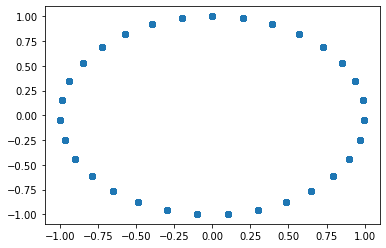

In [15]:
plt.scatter(df_train_exog_transformed['day_sin'], df_train_exog_transformed['day_cos'])

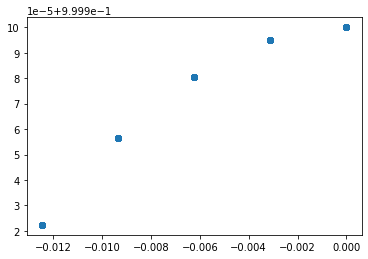

In [16]:
plt.scatter(df_train_exog_transformed['year_sin'], df_train_exog_transformed['year_cos'])

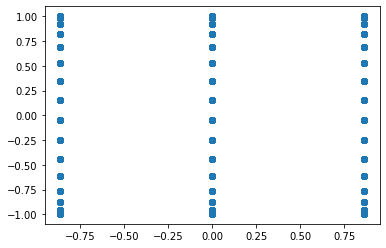

In [17]:
plt.scatter(df_train_exog_transformed['dayofweek_sin'], df_train_exog_transformed['day_cos'])

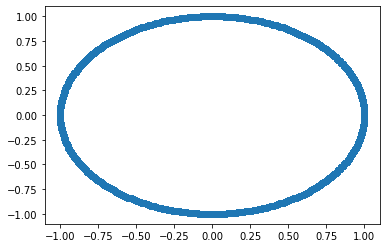

In [18]:
plt.scatter(df_train_exog_transformed['dayofyear_sin'], df_train_exog_transformed['dayofyear_cos'])

As can be seen above, when plotted together, the two columns represent distinct vectors that have some kind of relationship with each other. We will try to use this to conduct ARIMAX.

Note that SARIMAX cannot be done due to high required processing power for seasonality.

In [19]:
exog_train = df_train_exog_transformed.drop(['day', 'month', 'year', 'dayofweek', 'dayofyear'], axis=1)
exog_test = df_test_exog_transformed.drop(['day', 'month', 'year', 'dayofweek', 'dayofyear'], axis=1)

### **ARIMAX with Trigonometric Encoding**

In [20]:
# output_df = pd.DataFrame(columns=df_test.columns)

# i = 1

# for index, row in df_permutations.iterrows():
#   # Train
#   df_individual_train = df_train[(df_train['store']==row['store'])
#   & (df_train['item']==row['item'])]

#   exog_train_individual = exog_train[(exog_train['store']==row['store'])
#   & (exog_train['item']==row['item'])].drop(['store', 'item', 'sales'], axis=1)


#   # Test
#   df_individual_test = df_test[(df_test['store']==row['store'])
#   & (df_test['item']==row['item'])]

#   exog_test_individual = exog_test[(exog_test['store']==row['store'])
#   & (exog_test['item']==row['item'])].drop(['store', 'item'], axis=1)

#   exog_test_individual = exog_test_individual.drop(['id'], axis=1)

#   # print(exog_test_individual)
#   # print(exog_train_individual)

#   # SARIMA
#   sarimax_eval = sm.tsa.statespace.SARIMAX(df_individual_train['sales'], 
#                                            exog=exog_train_individual, 
#                                            order=(7,0,1),
#                                            enforce_stationarity=False, 
#                                            enforce_invertibility=False,
#                                            freq='D'
#                                            ).fit()

#   forecast_sarimax = sarimax_eval.predict(start='2018-01-01', 
#                                           end='2018-03-31', 
#                                           exog=exog_test_individual)

#   df_individual_test['sales'] = forecast_sarimax
#   output_df = pd.concat([output_df,df_individual_test])

#   # if i%10 == 0:
#   print(i)
#   i+= 1

# output_df_2 = output_df[['id', 'store', 'item', 'sales']]
# output_df_2
# output_df_2.to_csv('results.csv')

Unfortunately, this method actually worsened the performance, with private and public scores of 29.72134 and 38.23257. It appears that the currently suggested alternative to one hot encoding was not performing well.

#### **Regular One Hot Encoding**

We tried the ordinary one hot encoding of exogeneous variables.

However, certain variables such as day of year, which resulted in significant model complexity (such as 365 more columns), were excluded. For those, we decided to leave them as continuous.

We used:

1.   Day of Week (Monday, Tuesday, ...)
2.   Month of Year
3.   Week of Year
4.   Week of Month
5.   Is Weekend (Boolean)
6.   Is Month Start (Boolean)
7.   Is Month End (Boolean)
8.   Quarter



In [21]:
# One hot Encoding

def generate_date_features(df):
        df['day'] = df.index.day
        df['month'] = df.index.month
        df['year'] = df.index.year
        df['day_of_week'] = df.index.dayofweek
        df['day_of_year'] = df.index.dayofyear
        df['week_of_year'] = df.index.weekofyear
        df['week_of_month'] = df['week_of_year'].values // 4.35
        df['is_wknd'] = df.index.weekday//4
        df['is_month_start'] = df.index.is_month_start.astype(int)
        df['is_month_end'] = df.index.is_month_end.astype(int)
        df['quarter'] = df.index.quarter
        
        df['is_Mon'] = np.where(df['day_of_week'] == 1, 1, 0)                                                                                            
        df['is_Tue'] = np.where(df['day_of_week'] == 2, 1, 0)                                                                                         
        df['is_Wed'] = np.where(df['day_of_week'] == 3, 1, 0)                                                                                         
        df['is_Thu'] = np.where(df['day_of_week'] == 4, 1, 0)                                                                                         
        df['is_Fri'] = np.where(df['day_of_week'] == 5, 1, 0)                                                                                         
        df['is_Sat'] = np.where(df['day_of_week'] == 6, 1, 0)                                                                                         
        df['is_Sun'] = np.where(df['day_of_week'] == 7, 1, 0)  
        
        return df

In [22]:
df_test = pd.read_csv("test.csv",parse_dates=['date'], index_col=1)
df_train = pd.read_csv("train.csv", parse_dates=['date'],index_col=0)

df_train_exog = generate_date_features(df_train)
df_test_exog = generate_date_features(df_test)

df_train_exog = df_train_exog.drop(['day_of_week'], axis = 1)
df_test_exog = df_test_exog.drop(['day_of_week'], axis = 1)

df_train_exog.head(3)

,store,item,sales,day,month,year,day_of_year,week_of_year,week_of_month,is_wknd,is_month_start,is_month_end,quarter,is_Mon,is_Tue,is_Wed,is_Thu,is_Fri,is_Sat,is_Sun
date,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,13,1,1,2013,1,1,0.0,0,1,0,1,1,0,0,0,0,0,0
2013-01-02,1,1,11,2,1,2013,2,1,0.0,0,0,0,1,0,1,0,0,0,0,0
2013-01-03,1,1,14,3,1,2013,3,1,0.0,0,0,0,1,0,0,1,0,0,0,0


In [45]:
# Splitting train set into train-validation

split_date = pd.datetime(2017,10,1)

df_train_split = df_train_exog.loc[df_train_exog.index < split_date]
df_valid_split = df_train_exog.loc[df_train_exog.index >= split_date]

output_df = pd.DataFrame(columns=['date','store','item','sales'])
output_df.set_index(['date'])

i = 1

for index, row in df_permutations.iterrows():
  # Train
  df_individual_train = df_train_split[(df_train_split['store']==row['store'])
  & (df_train_split['item']==row['item'])]

  exog_train_individual = df_train_split[(df_train_split['store']==row['store'])
  & (df_train_split['item']==row['item'])].drop(['store', 'item', 'sales'], axis=1)


  # Test
  df_individual_test = df_valid_split[(df_valid_split['store']==row['store'])
  & (df_valid_split['item']==row['item'])]

  df_individual_test = df_individual_test[['store', 'item']]

  exog_test_individual = df_valid_split[(df_valid_split['store']==row['store'])
  & (df_valid_split['item']==row['item'])].drop(['store', 'item', 'sales'], axis=1)


  # ARIMAX
  arimax_eval = sm.tsa.statespace.SARIMAX(df_individual_train['sales'], 
                                           exog=exog_train_individual, 
                                           order=(7,0,1),
                                           enforce_stationarity=False, 
                                           enforce_invertibility=False,
                                           freq='D'
                                           ).fit()

  forecast_arimax = arimax_eval.predict(start='2017-10-01', 
                                          end='2017-12-31', 
                                          exog=exog_test_individual)

  df_individual_test['sales'] = forecast_arimax
  output_df = pd.concat([output_df,df_individual_test])

  # if i%10 == 0:
  print(i)
  i+= 1

output_df_2 = output_df[['store', 'item', 'sales']]
output_df_2
output_df_2.to_csv('results.csv')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
# output_df = pd.DataFrame(columns=df_test.columns)

# i = 1

# for index, row in df_permutations.iterrows():
#   # Train
#   df_individual_train = df_train[(df_train['store']==row['store'])
#   & (df_train['item']==row['item'])]

#   exog_train_individual = df_train_exog[(df_train_exog['store']==row['store'])
#   & (df_train_exog['item']==row['item'])].drop(['store', 'item', 'sales'], axis=1)


#   # Test
#   df_individual_test = df_test[(df_test['store']==row['store'])
#   & (df_test['item']==row['item'])]

#   exog_test_individual = df_test_exog[(df_test_exog['store']==row['store'])
#   & (df_test_exog['item']==row['item'])].drop(['store', 'item'], axis=1)

#   exog_test_individual = exog_test_individual.drop(['id'], axis=1)

#   # print(exog_test_individual)
#   # print(exog_train_individual)

#   # ARIMAX
#   arimax_eval = sm.tsa.statespace.SARIMAX(df_individual_train['sales'], 
#                                            exog=exog_train_individual, 
#                                            order=(7,0,1),
#                                            enforce_stationarity=False, 
#                                            enforce_invertibility=False,
#                                            freq='D'
#                                            ).fit()

#   forecast_arimax = arimax_eval.predict(start='2018-01-01', 
#                                           end='2018-03-31', 
#                                           exog=exog_test_individual)

#   df_individual_test['sales'] = forecast_arimax
#   output_df = pd.concat([output_df,df_individual_test])

#   # if i%10 == 0:
#   print(i)
#   i+= 1

# output_df_2 = output_df[['id', 'store', 'item', 'sales']]
# output_df_2
# output_df_2.to_csv('results.csv')

In [ ]:
output_df_2

This managed to get a private and public score of 14.33237
and 15.75886 respectively, an improvement over 18 and 20 from the original arima.


### **Observing Underforecast and Applying Growth Factor**

When testing out the data, we observed that the model continuously underforecasted. As such, we implemented a growth factor which ranged from 1.01 to 1.03, in intervals 0f 0.05.

We observed that multiplying sales by a factor of 1.025 resulted in an improved private score of 13.77655 but a worsened public score of 16.50861.

In [ ]:
# output_df_2['sales'] = output_df_2['sales']*1.025

In [ ]:
# output_df_2.to_csv('results.csv')